# Generating MNIST images with DCGAN

In [ ]:
!pip install git+https://github.com/tensorflow/docs
!pip install git+https://github.com/tensorflow/examples.git

In [3]:
import tensorflow as tf

from tensorflow_examples.models.dcgan import dcgan

from dcgan import DCGAN
from util import GANMonitor, images_to_gif

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
INPUT_SHAPE = (28, 28, 1)

LATENT_DIM = 100

## Data loading and preprocessing

Load the MNIST training set images:

In [5]:
(images, labels), (_, _) = tf.keras.datasets.mnist.load_data()
images.shape

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

Reshape the images to `28 x 28 x 1` and normalize them to `[-1, 1]`:

In [6]:
images = images.reshape(images.shape[0], *INPUT_SHAPE).astype('float32')
images = (images - 127.5) / 127.5
images.shape

(60000, 28, 28, 1)

Shuffle and batch the data:

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## DCGAN (Deep Convolutional Generative Adversarial Network)

[DCGAN](https://arxiv.org/abs/1511.06434) is a CNN-based generative adversarial network for modeling images.

Its architecture has the following characteristics:
* pooling layers are replaced with strided convolutions (discriminator) and fractional-strided convolutions (generator)
* batch normalization is used in the discriminator and generator
* there are no fully connected hidden layers
* the generator uses the ReLU activation function in all layers except the last, which uses Tanh
* the discriminator uses the LeakyReLU activation function in all layers

### Generator

The generator receives a random noise vector as input and shapes it into an image of the desired size (`28 x 28 x 1` for MNIST) using upsampling layers (`tf.keras.layers.Conv2DTranspose`).

Import the model from the [DCGAN](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/dcgan/dcgan.py) implementation in the installed [tensorflow_examples](https://github.com/tensorflow/examples) package:

In [8]:
generator = dcgan.make_generator_model()

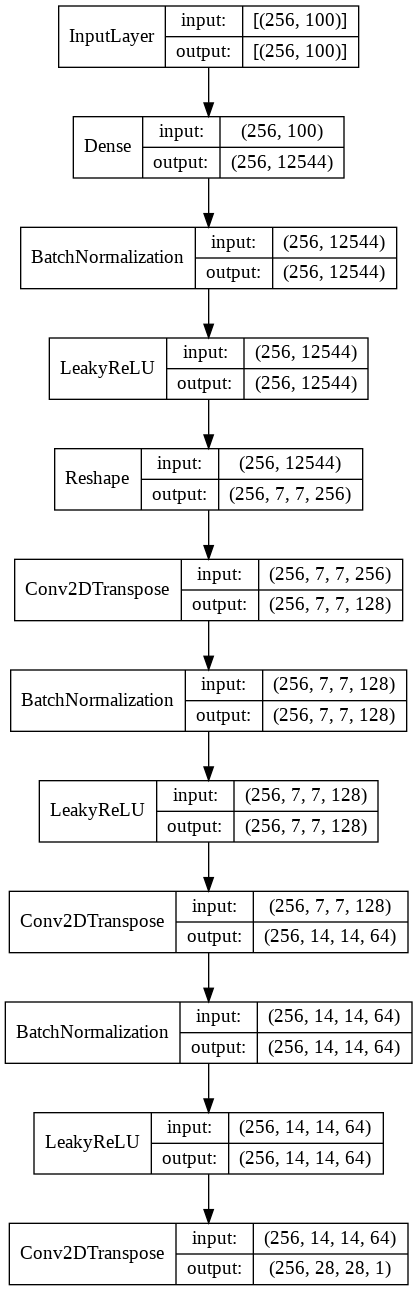

In [9]:
generator.build((BATCH_SIZE, LATENT_DIM))
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=False)

### Discriminator

The discriminator is a CNN-based binary classifier whose task is to differentiate between real images (from the training set) and generated images (created by the generator).

Import the model from the [DCGAN](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/dcgan/dcgan.py) implementation in the installed [tensorflow_examples](https://github.com/tensorflow/examples) package:

In [10]:
discriminator = dcgan.make_discriminator_model()

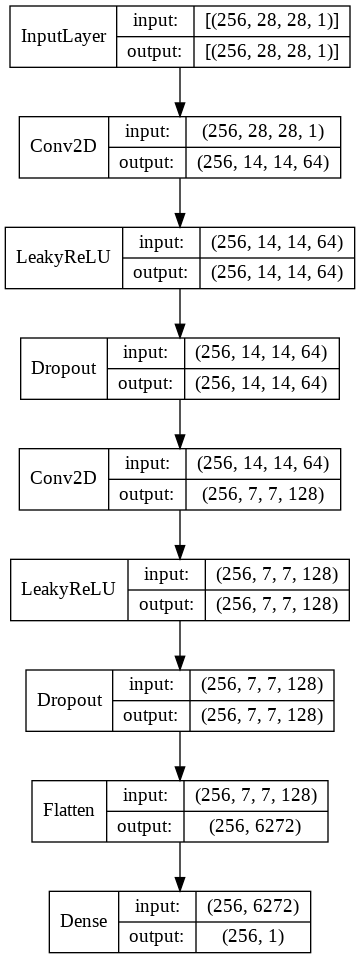

In [11]:
discriminator.build((BATCH_SIZE, *INPUT_SHAPE))
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=False)

### Training

The discriminator and the generator are trained simultaneously.

In each training step, the generator receives a batch of random noise vectors as input and uses it to generate a batch of images.
The discriminator is then used to classify real images (from the training set) and generated images (produced by the generator).
The loss is calculated for the discriminator and the generator respectively, and the resulting gradients are used to update them.

#### Discriminator loss

The discriminator's loss quantifies how well it distinguishes between real and generated images. As such, it is a sum of the losses computed on the real and fake outputs, respectively:

`d_loss = real_loss + fake_loss`

For the real component, the discriminator's predictions are compared to an array of 1s, and for the fake outputs to an array of 0s:

`real_loss = cross_entropy(tf.ones_like(real_output), real_output)`

`fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)`

#### Generator loss

The generator learns only through its interaction with the discriminator.
Its loss quantifies how well it fools the discriminator.

The generator performs well if the discriminator tends to misclassify the generated images as real (or 1).
Therefore, its loss is defined by comparing the discriminator's predictions on the fake images to an array of 1s:

`g_loss = cross_entropy(tf.ones_like(fake_output), fake_output)`

Create the `DCGAN` model:

In [12]:
dcgan = DCGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=LATENT_DIM)

Compile the model by adding the respective optimizers (two are needed because the discriminator and generator train seperately) and the base loss function:

Note that `from_logits` needs to be set to `True` as the discriminator outputs logits instead of probabilities.

In [13]:
dcgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True))

Finally, train the model:

Epoch 1/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0527 - g_loss: 0.9068

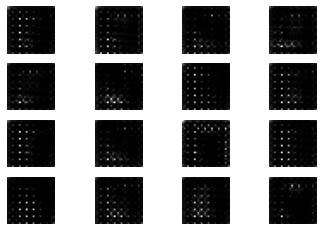

235/235 [==============================] - 28s 118ms/step - d_loss: 1.0527 - g_loss: 0.9068
Epoch 2/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0615 - g_loss: 1.3485

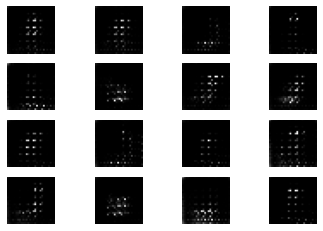

235/235 [==============================] - 27s 116ms/step - d_loss: 1.0615 - g_loss: 1.3485
Epoch 3/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9798 - g_loss: 1.4492

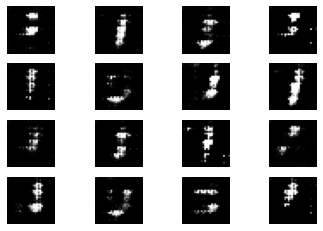

235/235 [==============================] - 28s 117ms/step - d_loss: 0.9798 - g_loss: 1.4492
Epoch 4/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9759 - g_loss: 1.2938

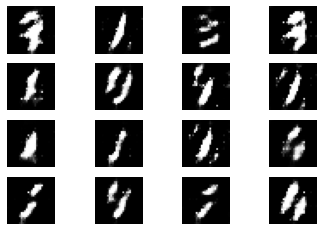

235/235 [==============================] - 27s 116ms/step - d_loss: 0.9759 - g_loss: 1.2938
Epoch 5/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0597 - g_loss: 1.2980

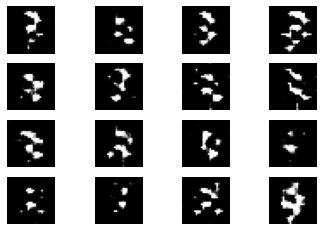

235/235 [==============================] - 27s 116ms/step - d_loss: 1.0597 - g_loss: 1.2980
Epoch 6/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1231 - g_loss: 1.1609

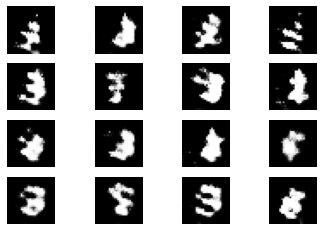

235/235 [==============================] - 27s 116ms/step - d_loss: 1.1231 - g_loss: 1.1609
Epoch 7/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0360 - g_loss: 1.2532

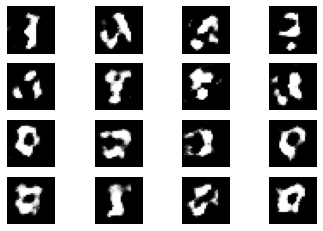

235/235 [==============================] - 27s 117ms/step - d_loss: 1.0360 - g_loss: 1.2532
Epoch 8/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0917 - g_loss: 1.2365

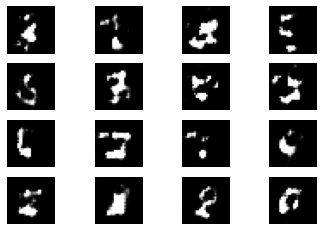

235/235 [==============================] - 27s 116ms/step - d_loss: 1.0917 - g_loss: 1.2365
Epoch 9/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9851 - g_loss: 1.4397

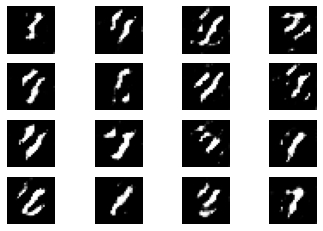

235/235 [==============================] - 27s 116ms/step - d_loss: 0.9851 - g_loss: 1.4397
Epoch 10/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9644 - g_loss: 1.4083

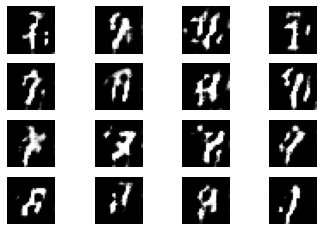

235/235 [==============================] - 28s 117ms/step - d_loss: 0.9644 - g_loss: 1.4083
Epoch 11/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0087 - g_loss: 1.3691

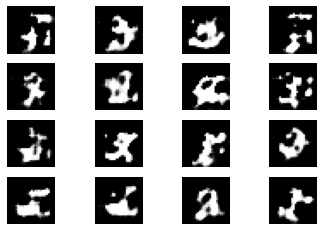

235/235 [==============================] - 28s 117ms/step - d_loss: 1.0087 - g_loss: 1.3691
Epoch 12/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9878 - g_loss: 1.4099

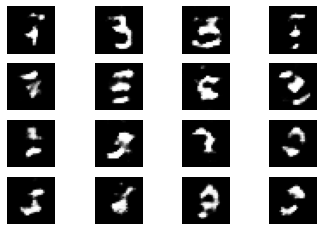

235/235 [==============================] - 28s 117ms/step - d_loss: 0.9878 - g_loss: 1.4099
Epoch 13/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0129 - g_loss: 1.4086

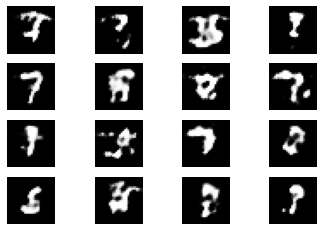

235/235 [==============================] - 27s 117ms/step - d_loss: 1.0129 - g_loss: 1.4086
Epoch 14/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9204 - g_loss: 1.5143

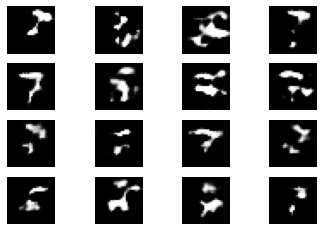

235/235 [==============================] - 28s 117ms/step - d_loss: 0.9204 - g_loss: 1.5143
Epoch 15/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9669 - g_loss: 1.5347

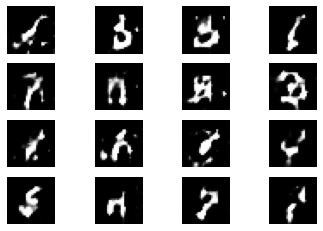

235/235 [==============================] - 28s 117ms/step - d_loss: 0.9669 - g_loss: 1.5347
Epoch 16/50
235/235 [==============================] - ETA: 0s - d_loss: 0.8645 - g_loss: 1.6353

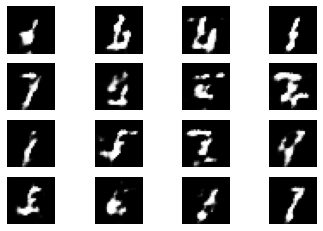

235/235 [==============================] - 28s 117ms/step - d_loss: 0.8645 - g_loss: 1.6353
Epoch 17/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9180 - g_loss: 1.6328

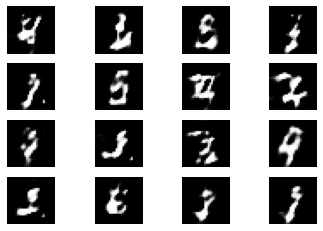

235/235 [==============================] - 28s 117ms/step - d_loss: 0.9180 - g_loss: 1.6328
Epoch 18/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9388 - g_loss: 1.5223

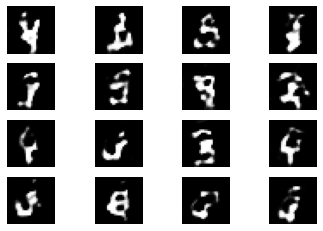

235/235 [==============================] - 28s 118ms/step - d_loss: 0.9388 - g_loss: 1.5223
Epoch 19/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9130 - g_loss: 1.5398

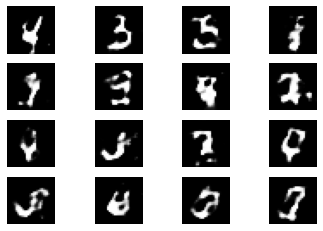

235/235 [==============================] - 28s 117ms/step - d_loss: 0.9130 - g_loss: 1.5398
Epoch 20/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9417 - g_loss: 1.5349

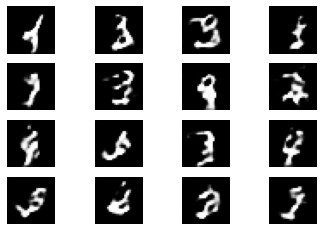

235/235 [==============================] - 28s 118ms/step - d_loss: 0.9417 - g_loss: 1.5349
Epoch 21/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9244 - g_loss: 1.5801

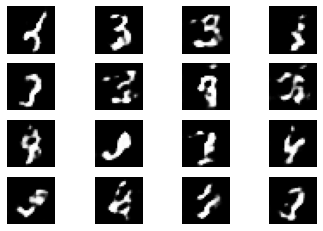

235/235 [==============================] - 28s 117ms/step - d_loss: 0.9244 - g_loss: 1.5801
Epoch 22/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9328 - g_loss: 1.6394

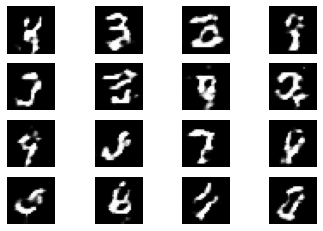

235/235 [==============================] - 28s 118ms/step - d_loss: 0.9328 - g_loss: 1.6394
Epoch 23/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9326 - g_loss: 1.6091

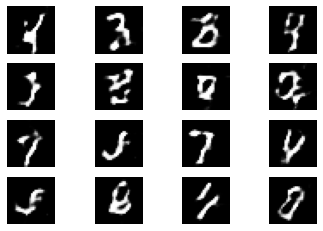

235/235 [==============================] - 28s 117ms/step - d_loss: 0.9326 - g_loss: 1.6091
Epoch 24/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9905 - g_loss: 1.5017

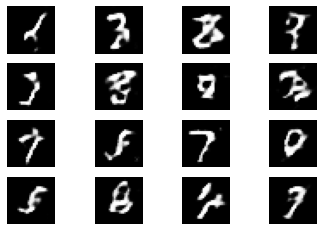

235/235 [==============================] - 28s 117ms/step - d_loss: 0.9905 - g_loss: 1.5017
Epoch 25/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0171 - g_loss: 1.4802

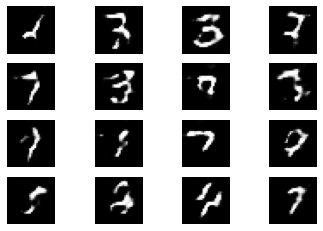

235/235 [==============================] - 28s 118ms/step - d_loss: 1.0171 - g_loss: 1.4802
Epoch 26/50
235/235 [==============================] - ETA: 0s - d_loss: 0.9566 - g_loss: 1.5525

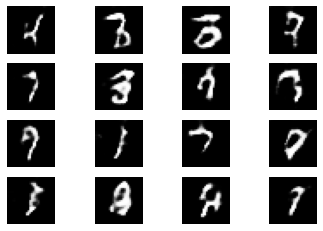

235/235 [==============================] - 28s 118ms/step - d_loss: 0.9566 - g_loss: 1.5525
Epoch 27/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0108 - g_loss: 1.3877

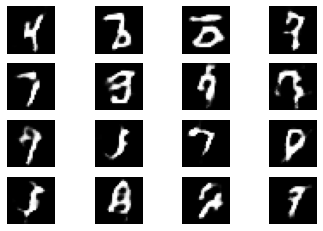

235/235 [==============================] - 28s 118ms/step - d_loss: 1.0108 - g_loss: 1.3877
Epoch 28/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0285 - g_loss: 1.3925

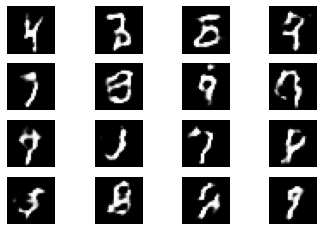

235/235 [==============================] - 28s 117ms/step - d_loss: 1.0285 - g_loss: 1.3925
Epoch 29/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0444 - g_loss: 1.3694

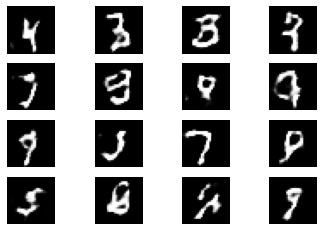

235/235 [==============================] - 28s 119ms/step - d_loss: 1.0444 - g_loss: 1.3694
Epoch 30/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0357 - g_loss: 1.4180

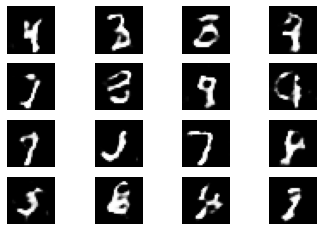

235/235 [==============================] - 28s 117ms/step - d_loss: 1.0357 - g_loss: 1.4180
Epoch 31/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0489 - g_loss: 1.3886

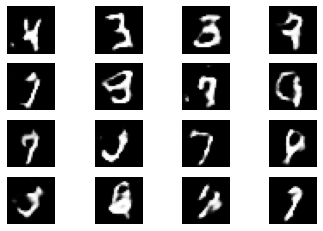

235/235 [==============================] - 28s 117ms/step - d_loss: 1.0489 - g_loss: 1.3886
Epoch 32/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0747 - g_loss: 1.3050

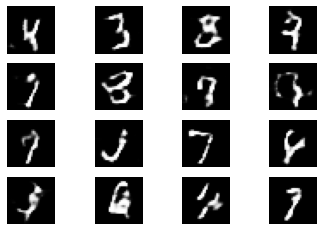

235/235 [==============================] - 28s 117ms/step - d_loss: 1.0747 - g_loss: 1.3050
Epoch 33/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0946 - g_loss: 1.2642

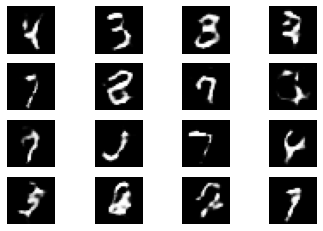

235/235 [==============================] - 28s 118ms/step - d_loss: 1.0946 - g_loss: 1.2642
Epoch 34/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0818 - g_loss: 1.2505

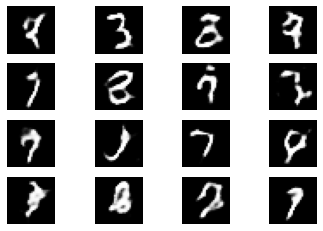

235/235 [==============================] - 28s 117ms/step - d_loss: 1.0818 - g_loss: 1.2505
Epoch 35/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1089 - g_loss: 1.2044

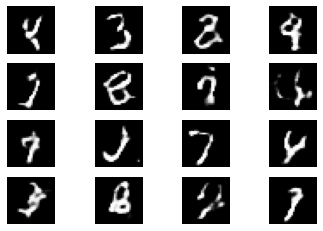

235/235 [==============================] - 27s 116ms/step - d_loss: 1.1089 - g_loss: 1.2044
Epoch 36/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1022 - g_loss: 1.2342

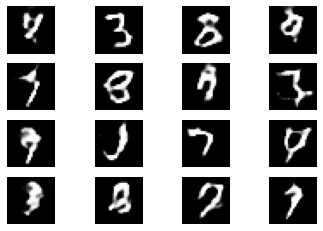

235/235 [==============================] - 27s 116ms/step - d_loss: 1.1022 - g_loss: 1.2342
Epoch 37/50
235/235 [==============================] - ETA: 0s - d_loss: 1.0927 - g_loss: 1.3020

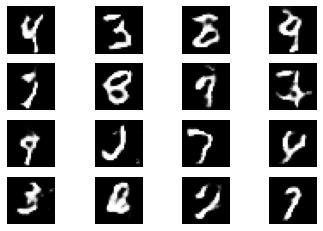

235/235 [==============================] - 27s 116ms/step - d_loss: 1.0927 - g_loss: 1.3020
Epoch 38/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1097 - g_loss: 1.2498

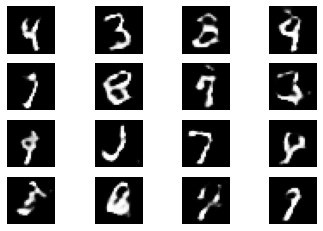

235/235 [==============================] - 28s 117ms/step - d_loss: 1.1097 - g_loss: 1.2498
Epoch 39/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1156 - g_loss: 1.2142

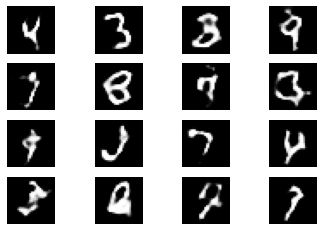

235/235 [==============================] - 27s 116ms/step - d_loss: 1.1156 - g_loss: 1.2142
Epoch 40/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1479 - g_loss: 1.1496

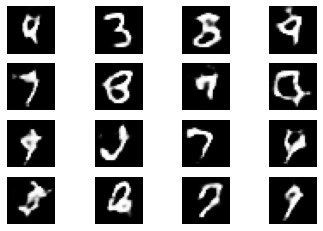

235/235 [==============================] - 28s 117ms/step - d_loss: 1.1479 - g_loss: 1.1496
Epoch 41/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1331 - g_loss: 1.1650

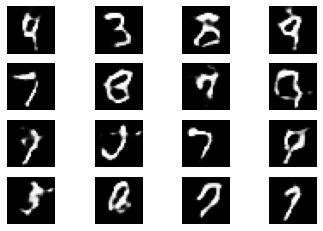

235/235 [==============================] - 27s 116ms/step - d_loss: 1.1331 - g_loss: 1.1650
Epoch 42/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1368 - g_loss: 1.1842

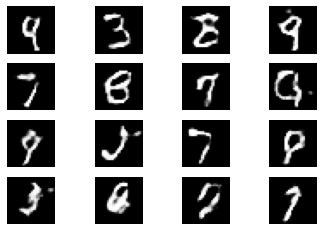

235/235 [==============================] - 27s 117ms/step - d_loss: 1.1368 - g_loss: 1.1842
Epoch 43/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1421 - g_loss: 1.1370

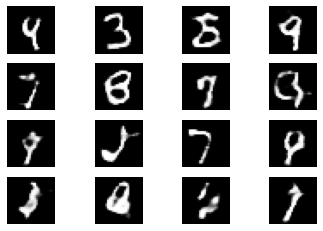

235/235 [==============================] - 27s 117ms/step - d_loss: 1.1421 - g_loss: 1.1370
Epoch 44/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1582 - g_loss: 1.1097

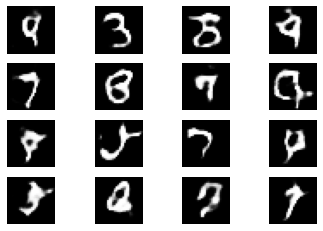

235/235 [==============================] - 28s 117ms/step - d_loss: 1.1582 - g_loss: 1.1097
Epoch 45/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1383 - g_loss: 1.1616

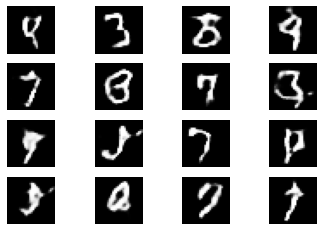

235/235 [==============================] - 27s 117ms/step - d_loss: 1.1383 - g_loss: 1.1616
Epoch 46/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1454 - g_loss: 1.1792

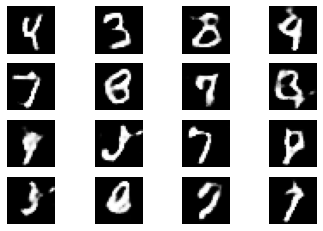

235/235 [==============================] - 28s 117ms/step - d_loss: 1.1454 - g_loss: 1.1792
Epoch 47/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1369 - g_loss: 1.1768

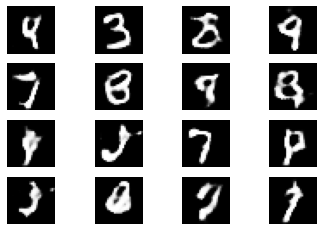

235/235 [==============================] - 28s 117ms/step - d_loss: 1.1369 - g_loss: 1.1768
Epoch 48/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1250 - g_loss: 1.2182

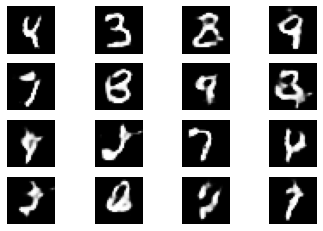

235/235 [==============================] - 27s 116ms/step - d_loss: 1.1250 - g_loss: 1.2182
Epoch 49/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1292 - g_loss: 1.1719

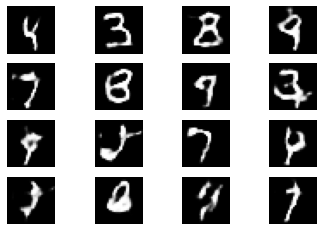

235/235 [==============================] - 27s 117ms/step - d_loss: 1.1292 - g_loss: 1.1719
Epoch 50/50
235/235 [==============================] - ETA: 0s - d_loss: 1.1380 - g_loss: 1.1308

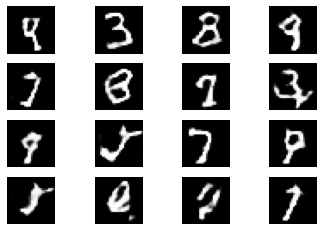

235/235 [==============================] - 27s 116ms/step - d_loss: 1.1380 - g_loss: 1.1308


In [15]:
dcgan.fit(
    dataset,
    epochs=50,
    callbacks=[GANMonitor(num_images=16, latent_dim=LATENT_DIM, path_prefix='images/dcgan_mnist')])

In [23]:
import time

weights_path = f'training/dcgan_mnist_{time.strftime("%Y%m%d%H%M%S")}.h5'
dcgan.save_weights(weights_path)

In [24]:
gif_path = 'images/dcgan_mnist.gif'

images_to_gif(image_pattern='images/dcgan_mnist*.png', gif_path=gif_path)


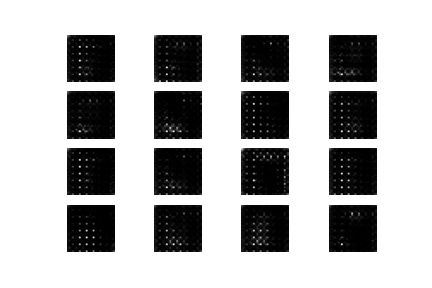

In [29]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(gif_path)